## Install and import all the needed dependencies

In [1]:
! pip install geopy
! pip install folium
! pip install bs4

import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

     |████████████████████████████████| 111 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 1.1 MB/s eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=6959807cf227710c3dcd12cf4d5baef5a4947da99d30f7963efeff3e069916c6
  Stored in directory: /home/jovyan/.cache/pip/wheels/75/78/21/68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
Successfully built bs4


## Extract Barcelona's district and barrios from Wikipedia

In [2]:
wikipedia_url = 'https://en.wikipedia.org/wiki/Districts_of_Barcelona'
response = requests.get(wikipedia_url)
soup = BeautifulSoup(response.text, 'html.parser')

districts_table = soup.find('table', class_='wikitable')
columns = ['District', 'Barrio']
barrios_list = []

for row in districts_table.findAll('tr'):
    cells = row.findAll('td')

    if cells:
        district = cells[1].find(text=True).rstrip()
        barrios = cells[5].findAll(text=True)
        barrios = [b for b in barrios if b not in (', ', '\n', '.\n', '*\n', '*, ', ' i ')]

        for barrio in barrios:
            barrios_list.append([district, barrio])

barcelona_barrios = pd.DataFrame(barrios_list, columns=columns)
barcelona_barrios.head()

,District,Barrio
0,Ciutat Vella,La Barceloneta
1,Ciutat Vella,El Gòtic
2,Ciutat Vella,El Raval
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera"
4,Eixample,L'Antiga Esquerra de l'Eixample


In [3]:
import time

geolocator = Nominatim(user_agent='bcn_explr')
lat_lng = []

for i, row in barcelona_barrios.iterrows():
    barrio = row['Barrio']
    location = geolocator.geocode(barrio)
    
    if location:
        lat_lng.append([location.latitude, location.longitude])
    else:
        lat_lng.append([np.nan, np.nan])
        print('Can\'t find lat long for barrio {}'.format(barrio))
    
    # Avoid rate limiting
    time.sleep(0.5)

barcelona_barrios[['Latitude', 'Longitude']] = lat_lng
barcelona_barrios

,District,Barrio,Latitude,Longitude
0,Ciutat Vella,La Barceloneta,41.380653,2.189927
1,Ciutat Vella,El Gòtic,41.383395,2.176912
2,Ciutat Vella,El Raval,41.379518,2.168368
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.388322,2.177411
4,Eixample,L'Antiga Esquerra de l'Eixample,41.390000,2.155000
...,...,...,...,...
70,Sant Martí,Poblenou,41.400527,2.201729
71,Sant Martí,Provençals del Poblenou,41.411948,2.204125
72,Sant Martí,Sant Martí de Provençals,41.416519,2.198968
73,Sant Martí,La Verneda i la Pau,41.423220,2.202940


## Backup the dataframe to CSV for future usage

In [4]:
barcelona_barrios.to_csv('barcelona_barrios.csv')

### Explore interesting venues in all those Barrios

In [69]:
import time

CLIENT_ID = 'F3M3AQG55E5IS2WDT33GL4M1F4SKNVYA3QT3R5IWS5FX051L'
CLIENT_SECRET = 'HOGDP1OL5I0FRJZAPWLLUDH3GKHGGPYYEJ4JA4DQ0ZJLOHX0'
VERSION = '20201224'
DEFAULT_RADIUS = 500
DEFAULT_LIMIT = 200

FOURSQUARE_BASE_EXPLORE_URL = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'

def explore_venues(dataframe):
    
    columns = ['Barrio', 'Barrio Latitude', 'Barrio Longitude',
                'Venue', 'Venue Latitude', 'Venue Longitude',
                'Category']

    venues_list = []
    
    for i, n in dataframe.iterrows():
        barrio = n['Barrio']
        latitude = n['Latitude']
        longitude = n['Longitude']

        explore_url = FOURSQUARE_BASE_EXPLORE_URL.format(CLIENT_ID,
                                                         CLIENT_SECRET,
                                                         VERSION,
                                                         latitude,
                                                         longitude,
                                                         DEFAULT_RADIUS,
                                                         DEFAULT_LIMIT)

        response = requests.get(explore_url).json()['response']
        
        try:
            response['groups']
        except KeyError:
            print(response)

        results = response['groups'][0]['items']        

        for r in results:
            data_row = [barrio, latitude, longitude,
                        r['venue']['name'], r['venue']['location']['lat'], r['venue']['location']['lng'],
                        r['venue']['categories'][0]['name']]

            venues_list.append(data_row)

        # Forcefully sleep the API call to avoid Foursquare API call threshold
        time.sleep(1)

    venues_df = pd.DataFrame(venues_list, columns=columns)

    return venues_df

In [70]:
barcelona_full_venues = explore_venues(barcelona_barrios)
barcelona_full_venues.to_csv('barcelona_full_venues.csv')

### Let's see how many Chinese restaurants are there and how the distribution looks like

In [195]:
def add_polygon_marker_to_map(lat_series, long_series, venue, color, fill_color, map_out):
    barcelona_locator = geolocator.geocode('Barcelona, ES')

    

    for lat, lng, label in zip(lat_series, long_series, venue):
        label = folium.Popup(label, parse_html=True)
        folium.RegularPolygonMarker(
            [lat, lng],
            number_of_sides=4,
            radius=6,
            popup=label,
            color=color,
            fill=True,
            fill_color=fill_color,
            fill_opacity=0.7,
            parse_html=False).add_to(map_out)  

In [197]:
import folium

barcelona_cn_restaurants = barcelona_full_venues[barcelona_full_venues['Category'] == 'Chinese Restaurant']
map_cn_restaurant = folium.Map(location=[barcelona_locator.latitude, barcelona_locator.longitude], zoom_start=13)

add_polygon_marker_to_map(barcelona_cn_restaurants['Venue Latitude'], \
                          barcelona_cn_restaurants['Venue Longitude'], \
                          barcelona_cn_restaurants['Venue'], \
                          'blue', \
                          '#3186cc', \
                          map_cn_restaurant)

map_cn_restaurant

<AxesSubplot:xlabel='Category'>

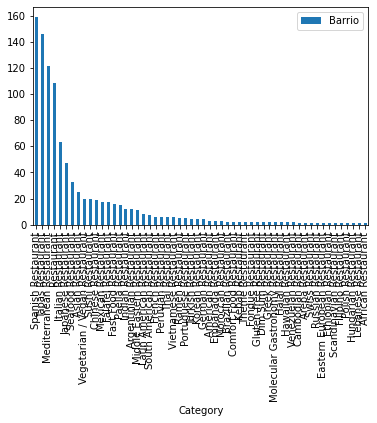

In [73]:
restaurant_counts = barcelona_full_venues[barcelona_full_venues['Category'].str.contains('Restaurant')].\
                    groupby('Category').count().sort_values('Barrio', ascending=False)

barcelona_restaurants = barcelona_full_venues.merge(restaurant_counts.reset_index(level=0)['Category'], how='inner')

# See data distribution

restaurant_counts.reset_index(level=0)[['Category', 'Barrio']].plot.bar(x='Category', y='Barrio')

### From the visualization above, it looks like there are not many Chinese restaurants in the whole city of Barcelona, making it a good opportunity for a potential new business. Let's now explore where would be the ideal place to open it

In [74]:
restaurant_onehot = pd.get_dummies(barcelona_restaurants[['Category']], prefix='', prefix_sep='')
restaurant_onehot['Barrio'] = barcelona_restaurants['Barrio']
columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[columns]
restaurant_onehot = restaurant_onehot.groupby('Barrio').mean().reset_index()

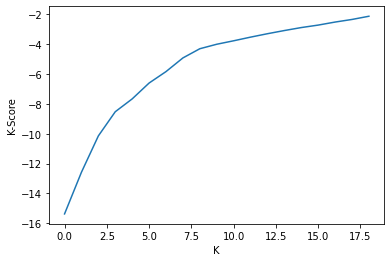

In [87]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

scores = []

restaurant_clustering = restaurant_onehot.drop('Barrio', axis=1)

for k in range(1, 20):
    scores.append(KMeans(n_clusters=k, random_state=1).fit(restaurant_clustering).score(restaurant_clustering))

plt.plot(scores)
plt.ylabel('K-Score')
plt.xlabel('K')
plt.show()

In [88]:
kclusters = 8
n = restaurant_onehot['Barrio']
barrio = restaurant_onehot[['Barrio']]
restaurant_clustering = restaurant_onehot.drop('Barrio', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(restaurant_clustering)
clusters_label = pd.DataFrame([x for x in kmeans.labels_], columns=['Cluster'])

barrio_cluster = pd.concat([clusters_label, barrio], axis=1)
barrio_cluster.groupby('Cluster').count()

,Barrio
Cluster,
0,22
1,3
2,3
3,1
4,12
5,2
6,1
7,23


In [89]:
top_restaurants = barcelona_restaurants[['Barrio', 'Barrio Latitude', 'Barrio Longitude', 'Category', 'Venue']].\
                groupby(by=['Barrio', 'Barrio Latitude', 'Barrio Longitude', 'Category']).count().reset_index().\
                groupby(by=['Barrio', 'Barrio Latitude', 'Barrio Longitude']).max().reset_index()

top_restaurants = top_restaurants.merge(barrio_cluster, on='Barrio', how='inner')

In [164]:
import random

def add_cluster_to_map(lat_series, long_series, label_series, cluster_series, target_map, colors):
    for lat, lon, barrio, cluster in zip(lat_series, long_series, label_series, cluster_series):
        label = folium.Popup('{}: Cluster {}'.format(barrio, cluster), parse_html=True)
        folium.CircleMarker([lat, lon],
                            radius=5,
                            popup=label,
                            color='#000000',
                            fill=True,
                            fill_color=colors[cluster],
                            fill_opacity=1.0,
                            weight=2).add_to(target_map)

map_clusters = folium.Map(location=[barcelona_locator.latitude, barcelona_locator.longitude], zoom_start=13)
colors = ['#983a06', '#f57b27', '#0f8222', '#946bbd', '#1cad8e', '#374ae0', '#f5fa18', '#12d1fc']
add_cluster_to_map(top_restaurants['Barrio Latitude'],\
                  top_restaurants['Barrio Longitude'],\
                  top_restaurants['Barrio'],\
                  top_restaurants['Cluster'],\
                  map_clusters,
                  colors)
    
map_clusters

In [109]:
top_restaurants[['Cluster', 'Category', 'Barrio']].groupby(by=['Cluster', 'Category']).count()

Barrio
Cluster Category                             
0       Spanish Restaurant                  1
        Sushi Restaurant                    1
        Tapas Restaurant                    8
        Thai Restaurant                     1
        Turkish Restaurant                  1
        Vegetarian / Vegan Restaurant       6
        Venezuelan Restaurant               1
        Vietnamese Restaurant               3
1       Tapas Restaurant                    3
2       Mediterranean Restaurant            3
3       Portuguese Restaurant               1
4       Spanish Restaurant                  7
        Tapas Restaurant                    4
        Thai Restaurant                     1
5       Restaurant                          2
6       French Restaurant                   1
7       Tapas Restaurant                   15
        Theme Restaurant                    1
        Turkish Restaurant                  1
        Vegetarian / Vegan Restaurant       3
        Vietnamese Restaurant               3

### Initial analysis from the clustering

|Cluster #|Analysis                                                   |
|---------|-----------------------------------------------------------|
|0        |Barrios in this cluster have Tapas and Vegetarian listed as the top restaurant, with small amount of Vietnamese and other restaurant|
|1        |3 Barrios registered to have only Tapas restaurant as their top restaurant|
|2        |3 Barrios registered to have only Mediterranean restaurant as their top restaurant|
|3        |Only 1 Barrio falls under this category, with Portuguese restaurant being their top restaurant|
|4        |In this cluster, you can find Spanish restaurant being the top restaurant, followed by Tapas|
|5        |2 Barrios registered to have only generic type of restaurant as their top restaurant|
|6        |French restaurant is the top restaurant found in this cluster|
|7        |Tapas is the main top restaurant found in this cluster, followed by other type of restaurants|

From this result, we can extract couple of preliminary conclusion:
1. We can safely exclude the option of opening new restaurant in cluster 7, as we will be competing with bulk of Tapas restaurant here.
2. Cluster 0 may be a good candidate, considering there are number of restaurant varieties found.
3. For cluster 1-6, we may need to cross check with information about place of attractions to see the probability of customers coming to these areas.

Let's now see the mapping of place of attractions, utilizing the same Foursquare datasets.

In [173]:
potential_attractions = ['Bookstore','Boat or Ferry','Beach',\
                         'Bridge', 'Hotel','Plaza','Museum','Castle',\
                         'Station','University','Mall',\
                         'Stadium','Park','Monument','Theater','Gallery'\
                         'Boutique', 'Circus', 'Cultural Center', 'Department Store'\
                         'Electronics Store', 'Escape Room', 'Historic Site', \
                         'Hot Spring', 'Music Venue', 'Multiplex', 'Nightclub', \
                         'Wine']
barcelona_attractions = barcelona_full_venues[barcelona_full_venues['Category'].\
                                                str.contains('|'.join(potential_attractions))].reset_index()
barcelona_attractions

,index,Barrio,Barrio Latitude,Barrio Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,3,La Barceloneta,41.380653,2.189927,Plaça de la Barceloneta,41.379739,2.188135,Plaza
1,9,La Barceloneta,41.380653,2.189927,Vinoteca Voramar,41.380726,2.188315,Wine Shop
2,12,La Barceloneta,41.380653,2.189927,Platja de la Barceloneta (Playa de la Barcelon...,41.379610,2.193038,Beach
3,28,La Barceloneta,41.380653,2.189927,Passeig Marítim de la Barceloneta,41.380125,2.192824,Beach
4,54,La Barceloneta,41.380653,2.189927,Museu d'Història de Catalunya,41.380684,2.186023,History Museum
...,...,...,...,...,...,...,...,...
466,2966,la Vila Olímpica del Poblenou,41.389868,2.196846,Zich,41.387227,2.198070,Nightclub
467,2967,la Vila Olímpica del Poblenou,41.389868,2.196846,TRAM Ciutadella | Vila Olímpica,41.387483,2.192041,Tram Station
468,2971,la Vila Olímpica del Poblenou,41.389868,2.196846,Mokaï Beach Bar,41.390832,2.202319,Beach Bar
469,2980,la Vila Olímpica del Poblenou,41.389868,2.196846,Amalur,41.390301,2.201289,Beach Bar


In [176]:
from folium import plugins

attractions_list = list(barcelona_attractions[['Venue Latitude', 'Venue Longitude']].values)
attractions_map = folium.Map([barcelona_locator.latitude, barcelona_locator.longitude], zoom_start=13)
heat_map = plugins.HeatMap(attractions_list, name='Barcelona Attractions')
attractions_map.add_child(heat_map)
folium.LayerControl().add_to(attractions_map)

attractions_map

In [175]:
final_map = attractions_map

add_cluster_to_map(top_restaurants['Barrio Latitude'],\
                  top_restaurants['Barrio Longitude'],\
                  top_restaurants['Barrio'],\
                  top_restaurants['Cluster'],\
                  final_map,
                  colors)

final_map

### Potential places to setup the business

From the exercise above, we can see that most of attractions are covered within barrios in cluster 0 and cluster 7. As we are not going to consider barrios in cluster 7 due to Tapas restaurant being the dominant restaurant here, let's see all places in cluster 7 that we can consider. Note that these places are taken based on the close promximity of the Barrio to the attraction places, so the closer the Barrio to the red zone on the above heat map, the better.

1. Sant Antoni
2. Fort Pienc
3. El Parc i la Llacuna del Poblenou
4. Vila de Gràcia
5. Sagrada Familia
6. El camp de l'Arpa del Clot
7. El clot
8. La Vila Olimpica del Poblenou

The next s



In [198]:
r_barrios = ['Sant Antoni', 'Fort Pienc', 'el Parc i la Llacuna del Poblenou', 'Vila de Gràcia',\
            'Sagrada Família', 'El Camp de l\'Arpa del Clot', 'el Clot', 'la Vila Olímpica del Poblenou']

selected_barrios = top_restaurants[top_restaurants['Barrio'].isin(r_barrios)]

rec_map = attractions_map

add_cluster_to_map(selected_barrios['Barrio Latitude'],\
                  selected_barrios['Barrio Longitude'],\
                  selected_barrios['Barrio'],\
                  selected_barrios['Cluster'],\
                  rec_map,
                  colors)

add_polygon_marker_to_map(barcelona_cn_restaurants['Venue Latitude'], \
                          barcelona_cn_restaurants['Venue Longitude'], \
                          barcelona_cn_restaurants['Venue'], \
                          'blue', \
                          '#3186cc', \
                          rec_map)  
rec_map

From the analysis above, there are couple of Barrio that already has Chinese restaurants, such as:

1. El camp de l'Arpa del Clot & El clot with 3 restaurants surrounding these Barrios
2. Fort Pienc with 1 restaurant
3. Sant Antoni with 1 restaurant

We can exclude these areas from the recommendations, and the final 4 Barrios are listed below:

1. Vila de Gràcia
2. Sagrada Familia
3. El Parc i la Llacuna del Poblenou
4. La Vila Olimpica del Poblenou